## Libraries

In [1]:
# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import chi2_contingency
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster

## Data Cleaning

In [2]:
# Load the data and inspect the first few rows
df = pd.read_csv('../data/raw/311_Service_Requests_2024_2025_reduced.csv.bz2',
                 compression = 'bz2', low_memory = False)
df.head()

Created Date             Closed Date  \
0  12/31/2024 11:59:38 PM  01/01/2025 12:26:35 AM   
1  12/31/2024 11:59:33 PM  01/02/2025 05:08:17 PM   
2  12/31/2024 11:59:32 PM  01/01/2025 12:18:51 AM   
3  12/31/2024 11:59:31 PM  01/01/2025 09:01:36 AM   
4  12/31/2024 11:59:21 PM  01/01/2025 12:42:47 AM   

                       Agency Name       Complaint Type  \
0  New York City Police Department    Illegal Fireworks   
1  New York City Police Department  Noise - Residential   
2  New York City Police Department  Noise - Residential   
3  New York City Police Department  Noise - Residential   
4  New York City Police Department  Noise - Residential   

                Location Type Incident Zip      City   Borough   Latitude  \
0             Street/Sidewalk        11218       NaN  BROOKLYN  40.640915   
1  Residential Building/House        10466     BRONX     BRONX  40.891872   
2  Residential Building/House        11221  BROOKLYN  BROOKLYN  40.688335   
3  Residential Building/House        10466     BRONX     BRONX  40.891872   
4  Residential Building/House        11230  BROOKLYN  BROOKLYN  40.634745   

   Longitude  
0 -73.973642  
1 -73.860168  
2 -73.930144  
3 -73.860168  
4 -73.964936

In [3]:
# Normalize column names to snake case
df.columns = ['_'.join(column.split(' ')).lower() for column in df.columns]

In [4]:
# Inspect column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458311 entries, 0 to 3458310
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   created_date    object 
 1   closed_date     object 
 2   agency_name     object 
 3   complaint_type  object 
 4   location_type   object 
 5   incident_zip    object 
 6   city            object 
 7   borough         object 
 8   latitude        float64
 9   longitude       float64
dtypes: float64(2), object(8)
memory usage: 263.8+ MB


In [5]:
# Check missingness of columns
df.isnull().sum()

created_date           0
closed_date       107983
agency_name            0
complaint_type         0
location_type     416849
incident_zip       34384
city              161561
borough                0
latitude           53606
longitude          53606
dtype: int64

### Dealing with Time Columns

In [6]:
# Convert date columns to datetime types
df['created_date'] = pd.to_datetime(df['created_date'], format = "%m/%d/%Y %I:%M:%S %p")
df['closed_date'] = pd.to_datetime(df['closed_date'], format = "%m/%d/%Y %I:%M:%S %p")

# Replace NaT in closed date with last datetime of 2024
df['closed_date'] = df['closed_date'].fillna(pd.Timestamp("2024-12-31 23:59:59"))

# Truncate data to only include data where the incident occurred and resolved within 2024
df = df[(df['created_date'] >= '2024-01-01') & (df['created_date'] < '2025-01-01')]
df = df[(df['closed_date'] >= '2024-01-01') & (df['closed_date'] < '2025-01-01')]

In [7]:
# Create time of day category based on hour of incident
# Extract hour
hours = df['created_date'].dt.hour

# Define bins and labels
# 12AM-5:59AM = Night, 6AM-11:59AM = Morning, 12:00PM-5:59PM = Afternoon, 6:00PM-11:59PM = Night
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']

# Create a new column with time-of-day category
df['time_of_day'] = pd.cut(hours, bins = bins, labels = labels, right = False, include_lowest = True)

In [8]:
# Extract day of week and month from date of incident
df['day_of_week'] = df['created_date'].dt.day_name()
df['month'] = df['created_date'].dt.month_name()

# Extract hours passed until resolution and resolution status
# Event is assumed to be resolved if the closed date is not the maximum date in 2024
df['resolution_time_hours'] = ((df['closed_date'] - df['created_date']).dt.total_seconds()
                                   / 3600).round().astype(int)
df['resolved'] = df['closed_date'] != pd.Timestamp("2024-12-31 23:59:59")

In [9]:
# Drop original time columns, as they will no longer be used
df = df.drop(['created_date', 'closed_date'], axis = 1)

In [10]:
# Check if there are any negative resolution times
len(df[df['resolution_time_hours'] < 0])

767

In [11]:
# Only 767 records with negative resolution times (closed date < created date), so we will drop these records
df = df[df['resolution_time_hours'] >= 0]

In [12]:
# Check missingness of data again
df.isnull().sum()

agency_name                   0
complaint_type                0
location_type            400970
incident_zip              33675
city                     158496
borough                       0
latitude                  52730
longitude                 52730
time_of_day                   0
day_of_week                   0
month                         0
resolution_time_hours         0
resolved                      0
dtype: int64

### Check Target Variable (Agency Name)

In [13]:
# Only one instance of "3-1-1" and there are many categories with very few samples
df['agency_name'].value_counts()

agency_name
New York City Police Department                       1545766
Department of Housing Preservation and Development     710897
Department of Sanitation                               301513
Department of Transportation                           201862
Department of Environmental Protection                 189444
Department of Parks and Recreation                     126829
Department of Buildings                                 92369
Department of Health and Mental Hygiene                 68162
Department of Homeless Services                         51526
Taxi and Limousine Commission                           32598
Economic Development Corporation                        27491
Department of Consumer and Worker Protection            19326
Department of Education                                  1529
Office of Technology and Innovation                       154
3-1-1                                                       1
Name: count, dtype: int64

In [14]:
# Agencies which appear in low amounts of data will cause problems for modeling due to severe class imbalances
df['agency_name'].value_counts(normalize = True).round(4)

agency_name
New York City Police Department                       0.4588
Department of Housing Preservation and Development    0.2110
Department of Sanitation                              0.0895
Department of Transportation                          0.0599
Department of Environmental Protection                0.0562
Department of Parks and Recreation                    0.0376
Department of Buildings                               0.0274
Department of Health and Mental Hygiene               0.0202
Department of Homeless Services                       0.0153
Taxi and Limousine Commission                         0.0097
Economic Development Corporation                      0.0082
Department of Consumer and Worker Protection          0.0057
Department of Education                               0.0005
Office of Technology and Innovation                   0.0000
3-1-1                                                 0.0000
Name: proportion, dtype: float64

In [15]:
# We will wrap all of the agencies with less than 1% presence into a single "Other" category
df['agency_name'] = df['agency_name'].where(
    df['agency_name'].map(
        df['agency_name'].value_counts(normalize = True)
    ).gt(0.01), "Other"
)

In [16]:
# Checking agency name counts again - class imbalances are present but much improved
df['agency_name'].value_counts(normalize = True)

agency_name
New York City Police Department                       0.458757
Department of Housing Preservation and Development    0.210982
Department of Sanitation                              0.089484
Department of Transportation                          0.059909
Department of Environmental Protection                0.056224
Department of Parks and Recreation                    0.037641
Department of Buildings                               0.027414
Other                                                 0.024069
Department of Health and Mental Hygiene               0.020229
Department of Homeless Services                       0.015292
Name: proportion, dtype: float64

### Check Complaint Type

In [17]:
# There are many different complaint types, so it would be best to group these into categories of some sort
df['complaint_type'].unique()

array(['Noise - Commercial', 'Noise - Residential', 'Animal in a Park',
       'Rodent', 'Traffic Signal Condition', 'UNSANITARY CONDITION',
       'Noise - Park', 'Noise - Street/Sidewalk', 'Elevator', 'PLUMBING',
       'WATER LEAK', 'PAINT/PLASTER', 'Illegal Parking',
       'Non-Emergency Police Matter', 'Illegal Fireworks',
       'Noise - House of Worship', 'Blocked Driveway', 'Plumbing',
       'Taxi Complaint', 'Panhandling', 'Drug Activity',
       'Street Condition', 'Street Light Condition', 'Noise - Vehicle',
       'Water System', 'Drinking', 'For Hire Vehicle Report',
       'Root/Sewer/Sidewalk Condition', 'Encampment', 'Traffic',
       'Abandoned Vehicle', 'Noise', 'Animal-Abuse', 'Sewer',
       'Noise - Helicopter', 'Indoor Sewage', 'Bike/Roller/Skate Chronic',
       'Maintenance or Facility', 'ELECTRIC', 'APPLIANCE', 'DOOR/WINDOW',
       'GENERAL', 'Vendor Enforcement', 'Urinating in Public',
       'Unsanitary Animal Pvt Property', 'Real Time Enforcement',
      

In [18]:
# Creating a mapping for 12 different categories
# 1: Noise Complaints, 2: Animal-Relating Complaints, 3: Traffic & Parking
# 4: Sanitation & Maintenance, 5: Building & Facility Complaints, 6: Public Safety & Legal Issues
# 7. Environmental Complaints, 8: Property & Land Use, 9: Public Infrastructure & Transportation
# 10. Health & Food-Related, 11: Comunity Services & Outreach, 12: Other

# Mapping dictionary
complaint_mapping = {
    'Noise Complaints': [
        'Noise - Commercial', 'Noise - Residential', 'Noise - Park', 'Noise - Street/Sidewalk',
        'Noise - Vehicle', 'Noise - House of Worship', 'Noise - Helicopter', 'Noise'
    ],
    'Animal-Related Complaints': [
        'Animal in a Park', 'Rodent', 'Animal-Abuse', 'Unsanitary Animal Pvt Property', 
        'Unleashed Dog', 'Dead Animal', 'Animal Facility - No Permit', 
        'Unsanitary Animal Facility', 'Illegal Animal Sold', 'Illegal Animal Kept as Pet',
        'Harboring Bees/Wasps', 'Pet Shop', 'Unsanitary Pigeon Condition', 'Illegal Tree Damage'
    ],
    'Traffic & Parking': [
        'Bike/Roller/Skate Chronic', 'Derelict Vehicles', 'For Hire Vehicle Complaint',
        'Bike Rack Condition', 'AHV Inspection Unit', 'Stalled Sites',
        'Traffic Signal Condition', 'Illegal Parking', 'Blocked Driveway',
        'Taxi Complaint', 'For Hire Vehicle Report', 'Abandoned Vehicle', 'Street Condition',
        'Street Light Condition', 'Traffic', 'Taxi Compliment', 'Broken Parking Meter',
        'Street Sweeping Complaint', 'Street Sign - Damaged', 'Street Sign - Dangling',
        'Street Sign - Missing', 'Bus Stop Shelter Placement', 'Bus Stop Shelter Complaint',
        'Municipal Parking Facility', 'Highway Condition', 'Highway Sign - Damaged',
        'Highway Sign - Dangling', 'Highway Sign - Missing', 'Taxi Report', 'Green Taxi Report',
        'Green Taxi Complaint', 'Taxi Licensee Complaint', 'Dispatched Taxi Complaint',
        'FHV Licensee Complaint', 'Abandoned Bike', 'E-Scooter', 'Bike Rack', 'Tunnel Condition'
    ],
    'Building & Facility Complaints': [
        'UNSANITARY CONDITION', 'Sewer', 'Dirty Condition', 'Wood Pile Remaining', 'Mold',
        'OUTSIDE BUILDING', 'Peeling Paint', 'Non-Residential Heat', 'Elevator', 'Plumbing',
        'WATER LEAK', 'Boilers', 'APPLIANCE', 'DOOR/WINDOW', 'FLOORING/STAIRS', 'HEAT/HOT WATER',
        'Building/Use', 'Outdoor Dining', 'Building Condition', 'Maintenance or Facility',
        'Indoor Air Quality', 'Building Drinking Water Tank', 'Construction Safety Enforcement',
        'School Maintenance', 'Cooling Tower', 'Electrical', 'ELECTRIC', 'Cranes and Derricks',
        'Scaffold Safety', 'General Construction/Plumbing', 'Construction Lead Dust', 'Snow or Ice',
        'ELEVATOR', 'PLUMBING', 'PAINT/PLASTER', 'Indoor Sewage'
    ],
    'Public Safety & Legal Issues': [
        'Real Time Enforcement', 'Investigations and Discipline (IAD)',
        'Emergency Response Team (ERT)', 'Sanitation Worker or Vehicle Complaint',
        'Special Projects Inspection Team (SPIT)', 'Ferry Complaint', 'Lifeguard',
        'Building Marshals office', 'X-Ray Machine/Equipment', 'Non-Emergency Police Matter',
        'Drug Activity', 'Panhandling', 'Illegal Fireworks', 'Violation of Park Rules',
        'Encampment', 'Obstruction', 'Disorderly Youth', 'Smoking', 'Squeegee',
        'Public Payphone Complaint', 'Illegal Posting', 'Posting Advertisement',
        'SAFETY', 'Urinating in Public', 'Vendor Enforcement', 'Retailer Complaint',
        'Tobacco or Non-Tobacco Sale', 'BEST/Site Safety', 'Transfer Station Complaint',
        'Illegal Dumping', "Building Marshal's Office"
    ],
    'Environmental Complaints': [
        'Root/Sewer/Sidewalk Condition', 'Damaged Tree', 'Dead/Dying Tree',
        'Overgrown Tree/Branches', 'Sidewalk Condition', 'Curb Condition',
        'New Tree Request', 'Uprooted Stump', 'Lead', 'Bridge Condition',
        'Recycling Basket Complaint', 'Special Natural Area District (SNAD)',
        'Lot Condition', 'Air Quality', 'Water Conservation', 'Hazardous Materials',
        'Radioactive Material', 'Asbestos', 'Oil or Gas Spill', 'Mosquitoes',
        'Plant', 'DEP Highway Condition', 'Water System', 'Standing Water',
        'DEP Street Condition', 'DEP Sidewalk Condition', 'Industrial Waste'
    ],
    'Health & Food-Related': [
        'Food Poisoning', 'Food Establishment', 'Drinking', 'Drinking Water', 
        'Consumer Complaint', 'Building Drinking Water Tank', 'Mobile Food Vendor',
        'Dumpster Complaint', 'Water Quality', 'Institution Disposal Complaint',
        'Residential Disposal Complaint', 'Commercial Disposal Complaint'
    ],
    'Community Services & Outreach': [
        'Litter Basket Request', 'Litter Basket Complaint', 'Adopt-A-Basket', 'Bench',
        'Wayfinding', 'Seasonal Collection', 'DSNY Internal', 'SNW', 'Homeless Person Assistance',
        'Lost Property', 'Found Property', 'Consumer Complaint', 'Borough Office',
        'Special Operations', 'Executive Inspections', 'Sustainability Enforcement',
        'Dept of Investigations', 'Public Toilet', 'LinkNYC', 'Ferry Inquiry', 'Beach/Pool/Sauna Complaint'
    ]
}

# Invert the dictionary for mapping
inverse_mapping = {}
for category, types in complaint_mapping.items():
    for complaint in types:
        inverse_mapping[complaint] = category

# Map the complaint_type to categories, mapping unspecified complaint types to "Other"
df['complaint_type'] = df['complaint_type'].map(inverse_mapping).fillna('Other')

In [19]:
# Checking the counts for the new categories, these categories are more reasonable
df['complaint_type'].value_counts(normalize = True)

complaint_type
Traffic & Parking                 0.299681
Building & Facility Complaints    0.261096
Noise Complaints                  0.222405
Public Safety & Legal Issues      0.071372
Environmental Complaints          0.068032
Other                             0.024810
Animal-Related Complaints         0.022663
Community Services & Outreach     0.021204
Health & Food-Related             0.008737
Name: proportion, dtype: float64

### Location Type

In [20]:
# There are missing values in this column
df['location_type'].isnull().sum()

400970

In [21]:
# Like with the complaint type, there are a lot of unique location types
# It would be helpful to put these into categories
df['location_type'].unique()

array(['Store/Commercial', 'Residential Building/House', 'Park',
       'Commercial Building', nan, 'Club/Bar/Restaurant',
       'RESIDENTIAL BUILDING', 'Park/Playground', 'Street/Sidewalk',
       'House of Worship', 'Street', 'Subway', 'Other', 'Hallway',
       'Lobby', 'Highway', 'Above Address', '1-2 Family Dwelling',
       'Common Area', '3+ Family Apartment Building',
       'Other (Explain Below)', '3+ Family Apt. Building', 'Sidewalk',
       'Bridge', '3+ Family Mixed Use Building', 'Taxi', 'Curb',
       'Restaurant/Bar/Deli/Bakery', 'Public/Unfenced Area',
       'Street/Curbside', 'Comercial', 'Yard', 'Alley', 'Public Garden',
       'Construction Site', 'Intersection', 'Gutter', 'Business',
       'Residence', 'Vacant Lot', 'House and Store', 'Food Cart Vendor',
       'Traffic Island or Median', 'Residential Building', 'Mixed Use',
       'Residential', 'Bus Stop Shelter', 'Kennel/Animal Shelter',
       '1-2 Family Mixed Use Building', 'Retail Store',
       'Mobile F

In [22]:
# Creating a mapping for 6 different categories
# 1: Street, 2: Residential, 3: Commercial,
# 4: Restaurant, 5: Outdoor, 6: Other

# Mapping dictionary
location_mapping = {
    "Street": [
        'Street/Sidewalk', 'Street', 'Sidewalk', 'Highway', 'Intersection',
        'Alley', 'Curb', 'Street/Curbside', 'Taxi', 'Bus Stop Shelter',
        'Bike Lane', 'Vehicle Lane', 'Crosswalk', 'Speed Reducer',
        'Catch Basin/Sewer', 'Roadway Tunnel', 'Overpass', 'Public Stairs',
        'Street Area', 'Bridge', 'Gutter', 'Subway', 'Subway Station',
        'Street Fair Vendor'
    ],
    "Residential": [
        'Residential Building/House', 'RESIDENTIAL BUILDING', '1-2 Family Dwelling',
        '3+ Family Apartment Building', '3+ Family Apt. Building',
        '3+ Family Mixed Use Building', 'House and Store', 'Residence',
        'Residential Building', 'Residential', 'Private Residence',
        '1-3 Family Dwelling', '1-3 Family Mixed Use Building',
        '1-2 Family Mixed Use Building', 'Residential Property', 'Loft Residence',
        'Single Room Occupancy (SRO)', 'Nursing Home'
    ],
    "Commercial": [
        'Store/Commercial', 'Commercial Building', 'Comercial', 'Business',
        'Retail Store', 'Commercial', 'Commercial Property', 'Store',
        'Tire Shop', 'Groomer', 'Tanning Salon', 'Steam Room', 'Spa Pool',
        "Doctor's Office", 'Building (Non-Residential)', 'Office Building',
        'Medical Facility', 'Mixed Use Building', 'Sports Arena', 'Theater'
    ],
    "Restaurant": [
        'Club/Bar/Restaurant', 'Restaurant/Bar/Deli/Bakery', 'Food Cart Vendor',
        'Mobile Food Vendor', 'Food Establishment or Vendor', 'Restaurant',
        'Catering Service', 'Green Cart Vendor', 'Street Vendor',
        'Permanent Food Stand', 'Soup Kitchen', 'Cafeteria - Private',
        'Cafeteria - Private School', 'Cafeteria - Public School', 'Cafeteria - College/University'
    ],
    "Outdoor": [
        'Park', 'Park/Playground', 'Public/Unfenced Area', 'Yard',
        'Construction Site', 'Vacant Lot', 'Lot', 'Roof', 'Beach',
        'Ground', 'Pier', 'Wooded Area', 'Swamp or Pond', 'Horse Stable',
        'Petting Zoo/Animal Exhibit', 'Pool', 'Vacant Lot/Property', 'Parking Lot/Garage',
        'Parking Lot', 'Garage', 'Terminal', 'Ferry', 'Airport or Train/Bus Station',
        'Public Garden', 'Public Park/Garden', 'Public Garden/Park', 'Public Plaza',
        'Traffic Island or Median'
    ],
    "Other": [
        None, 'Other', 'House of Worship', 'Hallway', 'Lobby', 'Above Address',
        'Common Area', 'Other (Explain Below)', 'Kennel/Animal Shelter',
        'Inside', 'Vacant Building', 'Private Property', 'Abandoned Building',
        'Building Entrance', 'Building Condition', 'Building', 'Non-Profit',
        'Loft Building - Common Areas', 'Hospital', 'Cemetery', 'Senior Center',
        'Homeless Shelter', 'Sauna', 'Stairwell', 'Correctional Facility - City',
        'Correctional Facility - State', 'Mixed Use', 'Other (explain in Complaint Details)',
        'Government Building', 'School', 'School/Pre-School', 'Day Care/Nursery', 'School Safety Zone',
        'School - K-12 Public', 'School - K-12 Private', 'School - College/University'
    ]
}

# Invert the dictionary for mapping
inverse_mapping = {}
for category, types in location_mapping.items():
    for complaint in types:
        inverse_mapping[complaint] = category

# Map the location_type to categories, mapping unspecified complaint types to "Other"
df['location_type'] = df['location_type'].map(inverse_mapping).fillna('Other')

In [23]:
# Checking the counts for the new categories, these categories are more reasonable
df['location_type'].value_counts(normalize = True)

location_type
Street         0.463261
Residential    0.347715
Other          0.134256
Commercial     0.024554
Outdoor        0.018525
Restaurant     0.011690
Name: proportion, dtype: float64

### Location Data (City, Borough, Latitude/Longitude, and ZIP Code)

In [24]:
# There are a lot of values that need to be cleaned up, including null values
df['city'].unique()

array(['NEW YORK', 'STATEN ISLAND', 'BRONX', 'QUEENS', 'BROOKLYN',
       'OAKLAND GARDENS', nan, 'CORONA', 'JAMAICA', 'ASTORIA',
       'FOREST HILLS', 'FAR ROCKAWAY', 'ELMHURST', 'JACKSON HEIGHTS',
       'OZONE PARK', 'RIDGEWOOD', 'REGO PARK', 'COLLEGE POINT',
       'SOUTH RICHMOND HILL', 'EAST ELMHURST', 'MANHATTAN', 'WOODHAVEN',
       'SOUTH OZONE PARK', 'MASPETH', 'WOODSIDE', 'FLUSHING',
       'LITTLE NECK', 'SPRINGFIELD GARDENS', 'KEW GARDENS', 'WHITESTONE',
       'MIDDLE VILLAGE', 'BELLEROSE', 'FLORAL PARK', 'LONG ISLAND CITY',
       'ROSEDALE', 'FRESH MEADOWS', 'BAYSIDE', 'QUEENS VILLAGE',
       'HOWARD BEACH', 'SAINT ALBANS', 'SUNNYSIDE', 'RICHMOND HILL',
       'HOLLIS', 'ARVERNE', 'CAMBRIA HEIGHTS', 'GLEN OAKS',
       'NEW HYDE PARK', 'Nesconset', 'bronx', 'Staten Island', 'KATY',
       'Elmhurst', 'Manhattan', 'brooklyn', 'BREEZY POINT', 'Bentonville',
       'Brooklyn', 'New York', 'LAGUARDIA AIRPORT', 'Yonkers',
       'West Hempstead', 'La Grange', 'hicksville',

In [25]:
# Some of these locations are not in NYC, so let's preserve only locations in NYC and unknowns
nyc_areas = [
    'arverne', 'astoria', 'bayside', 'bellerose', 'breezy point', 'bronx',
    'brooklyn', 'cambria heights', 'college point', 'corona', 'east elmhurst',
    'elmhurst', 'far rockaway', 'flushing', 'forest hills', 'fresh meadows',
    'glen oaks', 'glendale queens', 'hollis', 'howard beach', 'jackson heights',
    'jamaica', 'jamaica queens', 'kew gardens', 'laguardia airport',
    'little neck', 'long island city', 'manhattan', 'maspeth', 'middle village',
    'new york', 'oakland gardens', 'ozone park', 'queens', 'queens village',
    'rego park', 'ridgewood', 'richmond hill', 'rosedale', 'saint albans',
    'south ozone park', 'south richmond hill', 'springfield boulevard',
    'springfield gardens', 'staten island', 'sunnyside', 'woodhaven', 'woodside',
    'whitestone', 'unknown'
]

# Convert city names to lowercase to normalize
df['city'] = df['city'].str.lower()

# Print number of dropped rows
print(f'Number of dropped rows: {len(df[(~df["city"].isin(nyc_areas)) & (df["city"].notna())])}')

# Drop all non-null rows outside of NYC
df = df[(df['city'].isin(nyc_areas)) | (df['city'].isna())]

Number of dropped rows: 1613


In [26]:
# The easiest way to impute the city is to use the borough name
# Checking that there are no rows where the city and borough are both null
df[(df['city'].isna()) & (df['borough'].isna())]

Empty DataFrame
Columns: [agency_name, complaint_type, location_type, incident_zip, city, borough, latitude, longitude, time_of_day, day_of_week, month, resolution_time_hours, resolved]
Index: []

In [27]:
# Impute missing values with borough names
df['city'] = df['city'].fillna(df['borough'].str.lower())

In [28]:
# Very few of the cities are prevalent enough to be worth using
# The most common "cities" are just borough names
df['city'].value_counts(normalize = True)[df['city'].value_counts(normalize = True).gt(0.01)].round(4)

city
brooklyn         0.3025
bronx            0.2141
new york         0.1895
staten island    0.0351
queens           0.0253
jamaica          0.0233
manhattan        0.0188
astoria          0.0170
flushing         0.0148
ridgewood        0.0115
Name: proportion, dtype: float64

In [29]:
# Even the "new york" designation is equivalent to Manhattan
df[df['city'] == 'new york'].borough.value_counts()

borough
MANHATTAN      638335
Unspecified        32
Name: count, dtype: int64

In [30]:
# Since the city is no longer useful, drop the city column
df = df.drop(['city'], axis = 1)

In [31]:
# Check the unique borough names, no null values
df['borough'].unique()

array(['MANHATTAN', 'STATEN ISLAND', 'BRONX', 'QUEENS', 'BROOKLYN',
       'Unspecified'], dtype=object)

In [32]:
# Check how many records have "Unspecified" as the borough
len(df[df['borough'] == 'Unspecified'])

2227

In [33]:
# Only 2135 records out of more than 3 million, we will drop these records
df = df[df['borough'] != 'Unspecified']

In [34]:
# There are a number of missing zip codes
df.incident_zip.isna().sum()

31684

In [35]:
# There are a lot of ZIP codes, let's check to make sure each are in NYC
df['incident_zip'].unique()

array(['10031', '10013', '10314', '10456', '10128', '11421', '10004',
       '10472', '11208', '11364', '10025', '10457', '11236', '11435',
       '11368', '11432', '11106', '10467', '11375', '10305', '11694',
       '11223', '10016', '11207', '11373', '11224', '11230', '11204',
       '11210', '11239', '10012', '11233', '11372', '11219', '11417',
       '11232', '11220', '11385', '10466', '10462', '10454', '11237',
       '11374', '10453', '10040', '11356', '10465', '10312', '11238',
       '11221', '11691', '10033', '10022', '10038', '11419', '10452',
       '10461', '11369', '10028', '10029', '11214', '11206', '10027',
       '11226', '10302', '11215', '10034', nan, '10455', '10030', '10007',
       '11235', '11358', '11201', '10009', '10001', '11420', '10039',
       '11212', '11378', '11377', '10003', '10459', '11216', '11355',
       '10019', '11222', '10463', '10024', '10002', '10304', '11211',
       '11370', '11365', '10451', '10310', '11218', '11234', '11205',
       '11362',

In [36]:
# ZIP codes from Zillow: https://www.zillow.com/browse/homes/ny/new-york-county/
nyc_zip = [
    "10001", "10002", "10003", "10004", "10005", "10006", "10007", "10008", "10009",
    "10010", "10011", "10012", "10013", "10014", "10015", "10016", "10017", "10018",
    "10019", "10020", "10021", "10022", "10023", "10024", "10025", "10026", "10027",
    "10028", "10029", "10030", "10031", "10032", "10033", "10034", "10035", "10036",
    "10037", "10038", "10039", "10040", "10041", "10043", "10044", "10045", "10046",
    "10047", "10048", "10049", "10050", "10051", "10052", "10053", "10054", "10055",
    "10056", "10057", "10058", "10059", "10060", "10061", "10062", "10063", "10064",
    "10065", "10066", "10067", "10068", "10069", "10070", "10071", "10072", "10073",
    "10074", "10075", "10076", "10077", "10078", "10079", "10080", "10081", "10082",
    "10083", "10084", "10085", "10086", "10087", "10088", "10089", "10090", "10091",
    "10092", "10093", "10094", "10095", "10096", "10097", "10098", "10099", "10101",
    "10102", "10103", "10104", "10105", "10106", "10107", "10108", "10109", "10110",
    "10111", "10112", "10113", "10114", "10115", "10116", "10117", "10118", "10119",
    "10120", "10121", "10122", "10123", "10124", "10125", "10126", "10127", "10128",
    "10129", "10130", "10131", "10132", "10133", "10134", "10135", "10136", "10137",
    "10138", "10139", "10140", "10141", "10142", "10143", "10144", "10145", "10146",
    "10147", "10148", "10149", "10150", "10151", "10152", "10153", "10154", "10155",
    "10156", "10157", "10158", "10159", "10160", "10161", "10162", "10163", "10164",
    "10165", "10166", "10167", "10168", "10169", "10170", "10171", "10172", "10173",
    "10174", "10175", "10176", "10177", "10178", "10179", "10180", "10181", "10182",
    "10183", "10184", "10185", "10186", "10187", "10188", "10189", "10190", "10191",
    "10192", "10193", "10194", "10195", "10196", "10197", "10198", "10199", "10201",
    "10202", "10203", "10204", "10205", "10206", "10207", "10208", "10209", "10210",
    "10211", "10212", "10213", "10214", "10215", "10216", "10217", "10218", "10219",
    "10220", "10221", "10222", "10223", "10224", "10225", "10226", "10227", "10228",
    "10229", "10230", "10231", "10232", "10233", "10234", "10235", "10236", "10237",
    "10238", "10239", "10240", "10241", "10242", "10243", "10244", "10245", "10246",
    "10247", "10248", "10249", "10250", "10251", "10252", "10253", "10254", "10255",
    "10256", "10257", "10258", "10259", "10260", "10261", "10262", "10263", "10264",
    "10265", "10266", "10267", "10268", "10269", "10270", "10271", "10272", "10273",
    "10274", "10275", "10276", "10277", "10278", "10279", "10280", "10281", "10282",
    "10283", "10284", "10285", "10286"
]

# Convert values in the column to None if not in the nyc_zip list
df['incident_zip'] = df['incident_zip'].apply(lambda x: x if x in nyc_zip else None)

In [37]:
# Want to impute missing ZIP codes using latitude and longitude
# Using GeoPandas and ZCTA shapefile from US Census: https://www2.census.gov/geo/tiger/TIGER2023/ZCTA520/
# Create Point geometry column
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis = 1)
gdf_points = gpd.GeoDataFrame(df, geometry = 'geometry', crs = 'EPSG:4326')

# Load the ZCTA shapefile
zcta = gpd.read_file('../data/raw/tl_2023_us_zcta520.shp')
zcta = zcta.to_crs('EPSG:4326')  # Ensure same coordinate system

# Spatial join: assign ZIP code to each point
gdf_joined = gpd.sjoin(gdf_points, zcta[['ZCTA5CE20', 'geometry']], how = 'left', predicate = 'within')

# Fill missing ZIP codes only
df['incident_zip'] = df['incident_zip'].fillna(gdf_joined['ZCTA5CE20'])

In [38]:
# For the remaining missing ZIP codes, impute using the mode from each borough (as borough is non-missing)
# Compute mode ZIP for each borough
mode_zip = df.dropna(subset = ['incident_zip']).groupby('borough')['incident_zip'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

# Create a mask for missing ZIPs
missing_mask = df['incident_zip'].isna()

# Fill missing ZIPs based on borough
df.loc[missing_mask, 'incident_zip'] = df.loc[missing_mask, 'borough'].map(mode_zip)

In [39]:
# Impute missing latitude and longitude values using the modes from the now non-missing ZIP column
# Calculate mode latitue/longitude per ZIP
lat_mode = df.dropna(subset = ['latitude']).groupby('incident_zip')['latitude'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)
lon_mode = df.dropna(subset = ['longitude']).groupby('incident_zip')['longitude'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

# Create masks for missing latitude/longitude
lat_missing = df['latitude'].isna()
lon_missing = df['longitude'].isna()

# Fill missing values using the ZIP mode mappings
df.loc[lat_missing, 'latitude'] = df.loc[lat_missing, 'incident_zip'].map(lat_mode)
df.loc[lon_missing, 'longitude'] = df.loc[lon_missing, 'incident_zip'].map(lon_mode)

# Drop geometry column
df = df.drop(['geometry'], axis = 1)

### Final Checks and Save in Preparation for EDA

In [40]:
# Check for missing values - should be none left
df.isnull().sum()

agency_name              0
complaint_type           0
location_type            0
incident_zip             0
borough                  0
latitude                 0
longitude                0
time_of_day              0
day_of_week              0
month                    0
resolution_time_hours    0
resolved                 0
dtype: int64

In [41]:
# Check data types, they seem appropriate
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3365627 entries, 64 to 3458310
Data columns (total 12 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   agency_name            object  
 1   complaint_type         object  
 2   location_type          object  
 3   incident_zip           object  
 4   borough                object  
 5   latitude               float64 
 6   longitude              float64 
 7   time_of_day            category
 8   day_of_week            object  
 9   month                  object  
 10  resolution_time_hours  int64   
 11  resolved               bool    
dtypes: bool(1), category(1), float64(2), int64(1), object(7)
memory usage: 288.9+ MB


In [42]:
# Save dataframe for further use in EDA without having to reclean the data
df.to_csv('../data/cleaned/311_Data_Cleaned_EDA.csv.bz2',
          compression = {'method': 'bz2', 'compresslevel': 9}, index = False)

## EDA

In [2]:
df = pd.read_csv('../data/cleaned/311_Data_Cleaned_EDA.csv.bz2', compression = 'bz2')

In [3]:
# Define agency acronyms for more concise names while plotting
agency_mapping = {
    "New York City Police Department": "NYPD",
    "Department of Housing Preservation and Development": "HPD",
    "Department of Sanitation": "DSNY",
    "Department of Transportation": "DOT",
    "Department of Environmental Protection": "DEP",
    "Department of Parks and Recreation": "DPR",
    "Department of Buildings": "DOB",
    "Other": "Other",
    "Department of Health and Mental Hygiene": "DOHMH",
    "Department of Homeless Services": "DHS"
}


# Add a column mapping the acronyms to the original names
df["agency_acronym"] = df["agency_name"].map(agency_mapping)

### Helper Functions

In [4]:
# Helper function to configure fontsizes for a Matplotlib axis
def format_axis(axis, title, xlabel, ylabel):
    """
    Format a matplotlib axis with consistent styling for title, labels, and ticks.

    Parameters:
    - axis: The matplotlib Axes object to format.
    - title: The title to set for the plot.
    - xlabel: The label for the x-axis.
    - ylabel: The label for the y-axis.
    """
    axis.set_title(title, fontsize = 20)
    axis.set_xlabel(xlabel, fontsize = 16)
    axis.set_ylabel(ylabel, fontsize = 16)
    axis.tick_params(axis = 'both', labelsize = 12)

    return

In [5]:
# Helper function add bar labels to a Matplotlib axis
def add_bar_labels(axis, fmt = '{:.2f}', fontsize = 12, color = 'black', offset = 5):
    """
    Add value labels on top of bars in a barplot.

    Parameters:
    - ax: matplotlib axis with bar containers (ax.patches).
    - fmt: format string for label (default: 2 decimal places).
    - fontsize: size of annotation text.
    - color: text color.
    - offset: vertical offset above the bar.
    """
    for p in axis.patches:
        height = p.get_height()
        axis.annotate(fmt.format(height),
                      (p.get_x() + p.get_width() / 2., height),
                      ha = 'center', va = 'center',
                      fontsize = fontsize, color = color,
                      xytext = (0, offset), textcoords = 'offset points')
    return

In [6]:
# Helper function to save plots to PNG files
def save_figure_to_png(fig, filename, dpi = 300):
    """
    Saves the given matplotlib figure to a PNG file with tight layout and high DPI.
    
    Parameters:
    - fig: Matplotlib figure object to be saved.
    - filename: String, the name of the file to save the figure as (including .png extension).
    - dpi: Integer, the resolution of the output image (default is 300).
    """
    # Apply tight layout to the figure
    fig.tight_layout()

    # Save the figure to the specified file with high DPI
    fig.savefig(filename, format = 'png', dpi = dpi)

    print(f"Figure saved as {filename} with {dpi} DPI.")

    return

### Raw Counts and Categorical Counts by Agency

The first thing to check is the raw counts of complaints by agency. The majority of complaints are directed towards the NYPD, followed by the Department of Housing Preservation and Development, then the Department of Sanitation and the Department of Transportation. The number of complaints trails off for the rest of the agencies. This indicates a large class imbalance that we will have to be aware of when modeling.

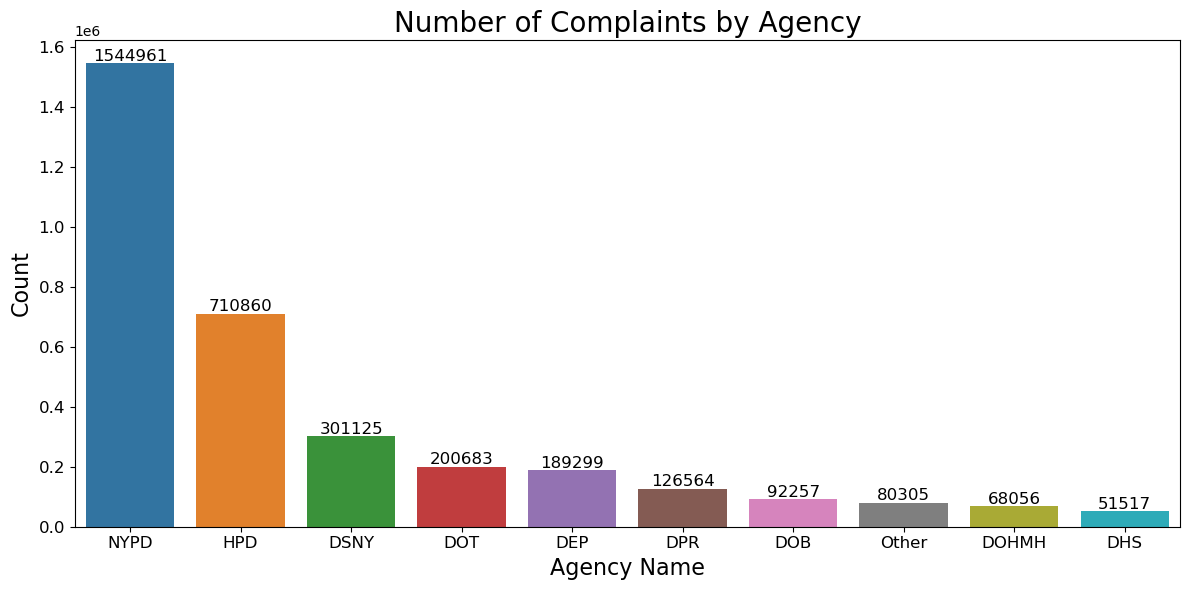

Figure saved as ../visualizations/complaints_by_agency.png with 300 DPI.


In [7]:
# Count of complaints per agency
agency_counts = df['agency_acronym'].value_counts()

# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = agency_counts.index, y = agency_counts.values, hue = agency_counts.index,
            palette = 'tab10', ax = ax)

# Add annotations
add_bar_labels(ax, fmt = '{:.0f}')

# Format plot
format_axis(ax, 'Number of Complaints by Agency', 'Agency Name', 'Count')

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/complaints_by_agency.png')

Looking at the complaint types that are distributed to agencies, noise, traffic complaints, and public safety complaints primarily go to the NYPD, while building complaints often go to the Department of Housing Preservation and Development. Many of the complaint types have clear agencies that take care of them, indicating good separability along this feature.

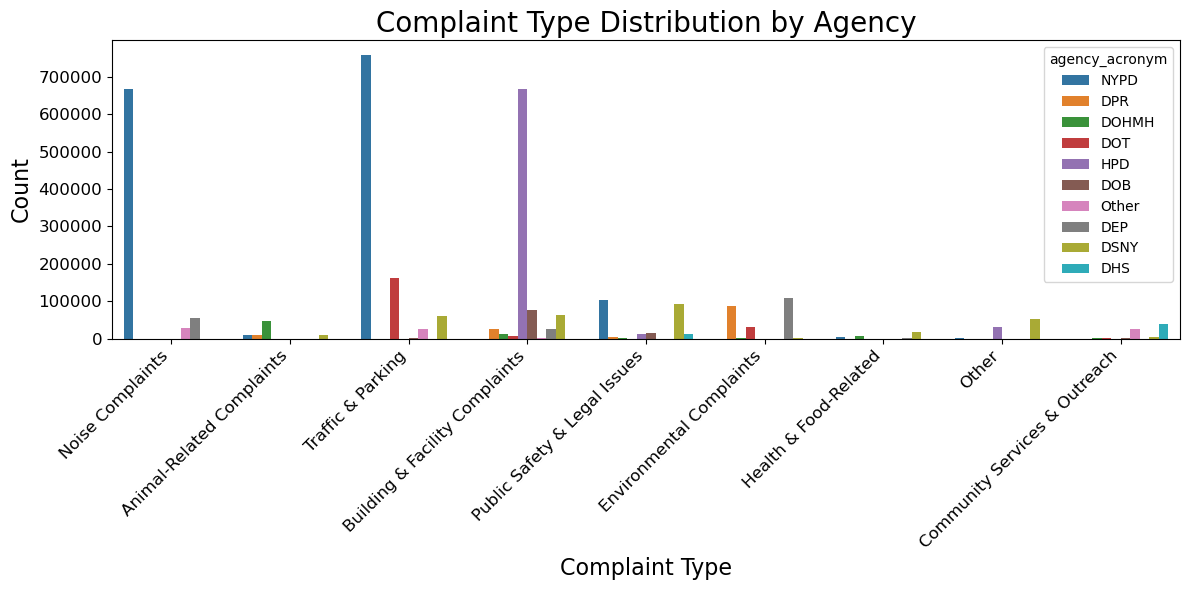

Figure saved as ../visualizations/complaint_type_by_agency.png with 300 DPI.


In [8]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'complaint_type', hue = 'agency_acronym', ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Complaint Type Distribution by Agency', 'Complaint Type', 'Count')

# Rotate x-ticks for better readability
plt.xticks(rotation = 45, ha = 'right')

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/complaint_type_by_agency.png')

The location type distribution by agency shows that most of the complaints that happen on the Street go to the NYPD, and most of the Residential complaints are split among the NYPD and the HPD. The other location types are not so obvious in terms of separation of agency.

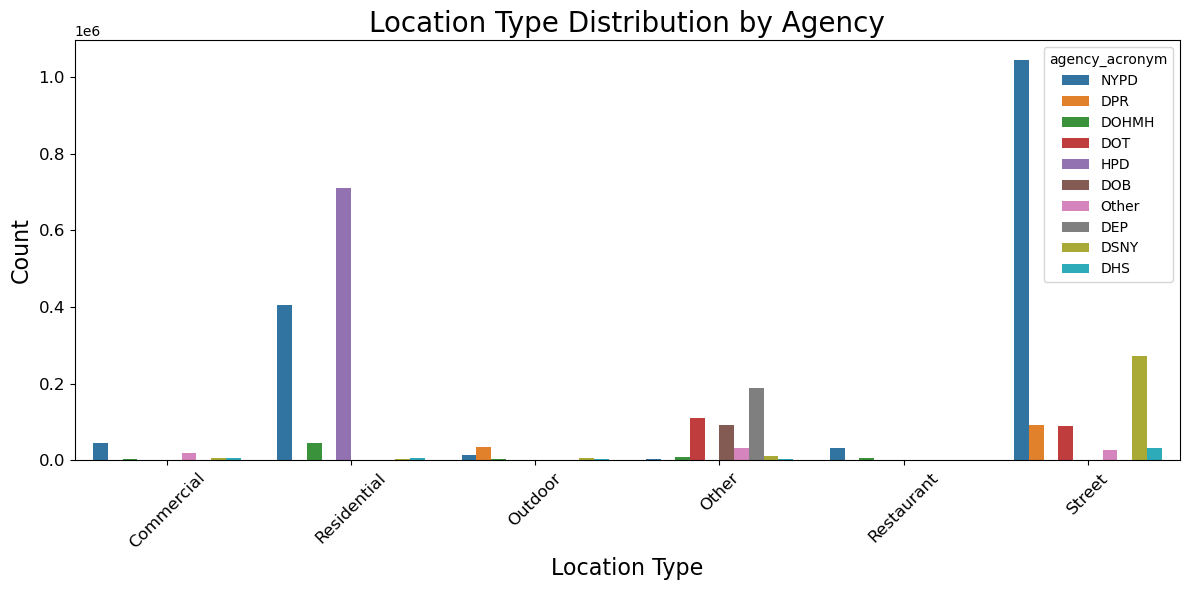

Figure saved as ../visualizations/location_type_by_agency.png with 300 DPI.


In [9]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'location_type', hue = 'agency_acronym', ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Location Type Distribution by Agency', 'Location Type', 'Count')

# Rotate x-ticks for better readability
plt.xticks(rotation = 45)

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/location_type_by_agency.png')

Viewing the Borough distribution by Agency reveals that most complaints in each Borough go to the NYPD. This should be obvious from the earlier Complaints by Agency chart, but this also reveals that certain Boroughs tend towards very different agencies to handle their complaints. The Bronx has the highest rate of complaints handled by the HPD, while Queens has almost all of its complaints handled by the NYPD.

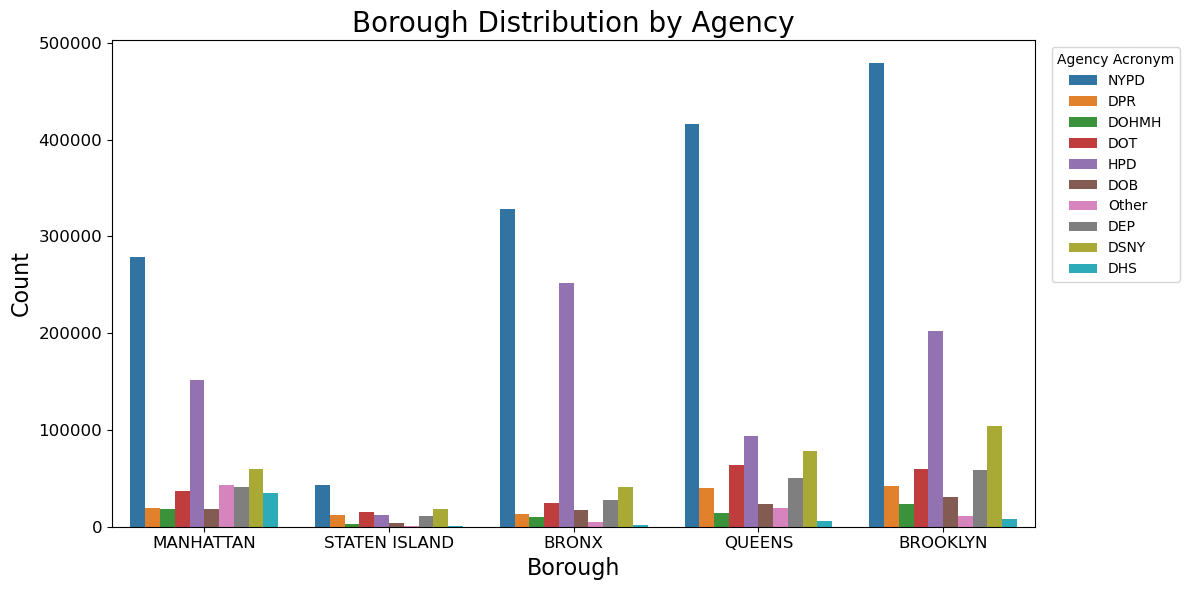

Figure saved as ../visualizations/borough_by_agency.png with 300 DPI.


In [10]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'borough', hue = 'agency_acronym', ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Borough Distribution by Agency', 'Borough', 'Count')

# Move legend to the right outside the plot
plt.legend(title = 'Agency Acronym', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/borough_by_agency.png')

Taking a closer look at complaint type by borough, a better picture is given. Queens has mostly Traffic complaints, followed by Noise and Building complaints, which were the top 3 categories typically handled by the NYPD. The Bronx has a much higher ratio of Building & Facility complaints which were often handled by HPD.

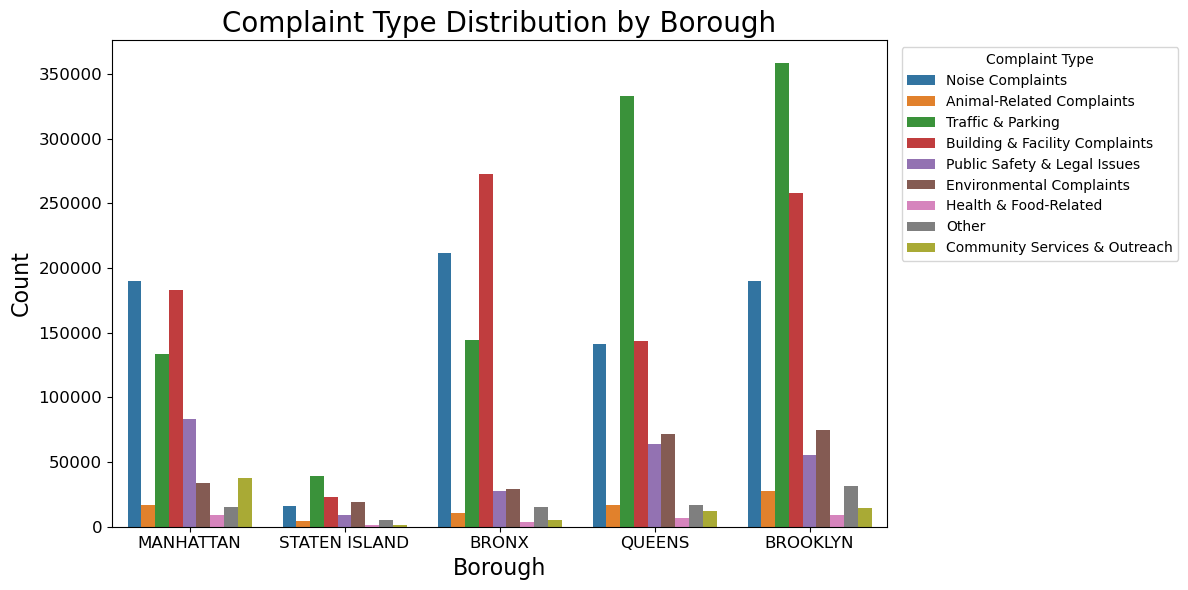

Figure saved as ../visualizations/complaint_type_by_borough.png with 300 DPI.


In [11]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'borough', hue = 'complaint_type', ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Complaint Type Distribution by Borough', 'Borough', 'Count')

# Move legend to the right outside the plot
plt.legend(title = 'Complaint Type', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/complaint_type_by_borough.png')

### Resolution Time and Completion Analysis

Although not useful for predicting where a complaint should be directed to, it is useful to know how long it takes to resolve complaints on average. The following plot shows that ~75% of resolved complaints are resolved in the first 24 hours, ~94% in the first month, ~98.5% in the first 3 months.

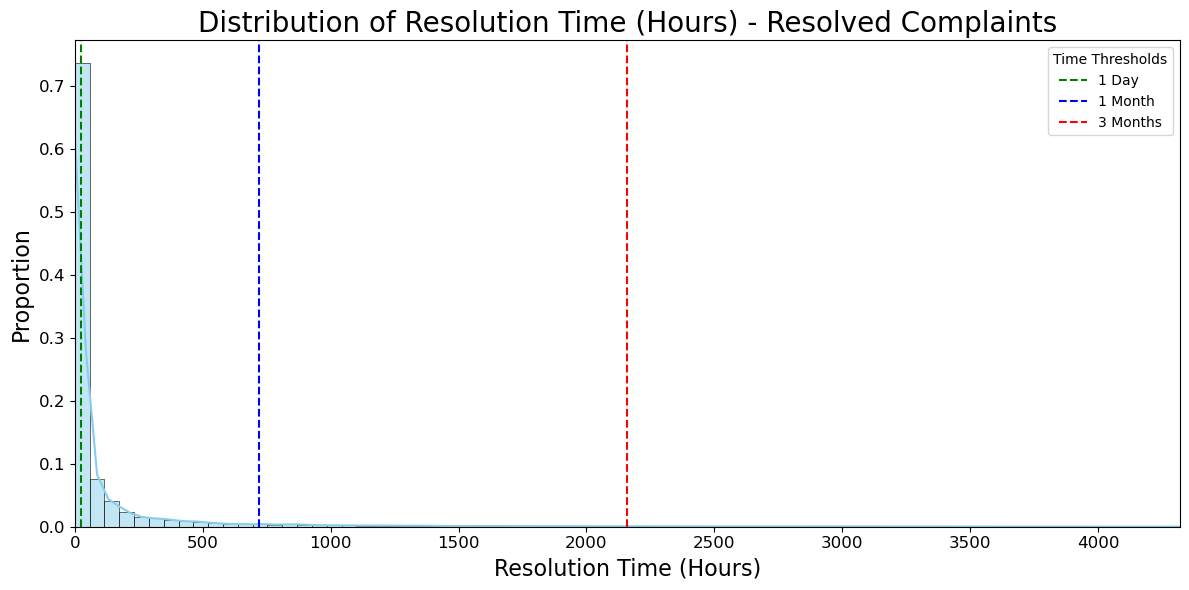

Figure saved as ../visualizations/resolution_time_distribution_resolved.png with 300 DPI.


In [12]:
# Filter the dataframe to only include resolved complaints
resolved_df = df[df['resolved'] == True]

# Define the thresholds in hours
one_day = 24  # 1 day in hours
one_month = 30 * 24  # 1 month in hours (approx. 30 days)
three_months = 3 * 30 * 24  # 3 months in hours (approx. 90 days)
six_months = 6 * 30 * 24  # 3 months in hours (approx. 90 days)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(resolved_df['resolution_time_hours'], bins = 150, kde = True,
             stat = 'probability', color = 'skyblue', ax = ax)

# Add dotted lines for 1 day, 1 month, and 3 months
ax.axvline(x = one_day, color = 'green', linestyle = '--', label = '1 Day')
ax.axvline(x = one_month, color = 'blue', linestyle = '--', label = '1 Month')
ax.axvline(x = three_months, color = 'red', linestyle = '--', label = '3 Months')

# Set x-axis limit to 6 months (approx. 180 days)
ax.set_xlim(0, six_months)

# Format plot
format_axis(ax, 'Distribution of Resolution Time (Hours) - Resolved Complaints',
            'Resolution Time (Hours)', 'Proportion')

# Add legend
plt.legend(title = "Time Thresholds")

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename='../visualizations/resolution_time_distribution_resolved.png')

Grouping by agency, we see that the NYPD usually resolves complaints very quickly (< 1 day), while agencies like the DPR (Department of Parks and Recreation) and DOB (Department of Buildings) take significantly longer to resolve complaints.

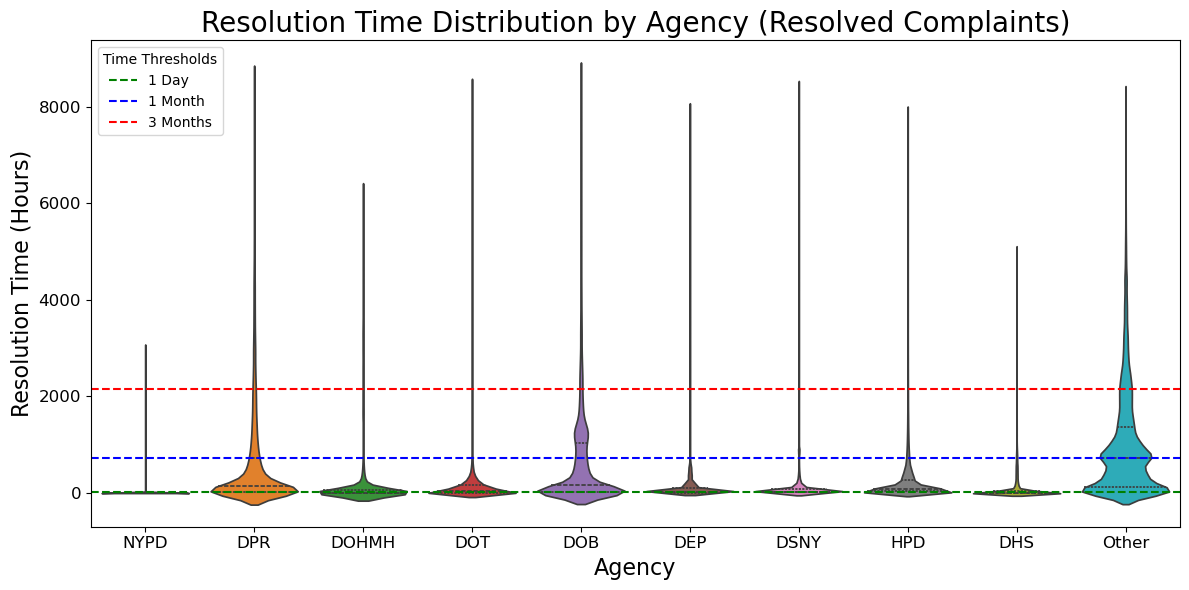

Figure saved as ../visualizations/resolution_time_by_agency_resolved.png with 300 DPI.


In [13]:
# Create the plot using the filtered dataframe (resolved_df)
fig, ax = plt.subplots(figsize = (12, 6))
sns.violinplot(data = resolved_df, x = 'agency_acronym', y = 'resolution_time_hours', hue = 'agency_acronym',
               inner = 'quartile', density_norm = 'width', ax = ax, palette = 'tab10')

# Add dotted lines for 1 day, 1 month, and 3 months
ax.axhline(y = one_day, color = 'green', linestyle = '--', label = '1 Day')
ax.axhline(y = one_month, color = 'blue', linestyle = '--', label = '1 Month')
ax.axhline(y = three_months, color = 'red', linestyle = '--', label = '3 Months')

# Format plot
format_axis(ax, 'Resolution Time Distribution by Agency (Resolved Complaints)', 'Agency', 'Resolution Time (Hours)')

# Add legend
plt.legend(title = "Time Thresholds", loc = "upper left")

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/resolution_time_by_agency_resolved.png')

The resolution rate per agency helps to determine how effective each agency is at resolving complaints. Most of the agencies have resolution ratios in the 94-100% range within 1 year (the span of the slice of data used), but the DHS (Department of Homeless Services) and DPR have much lower resolution rates.

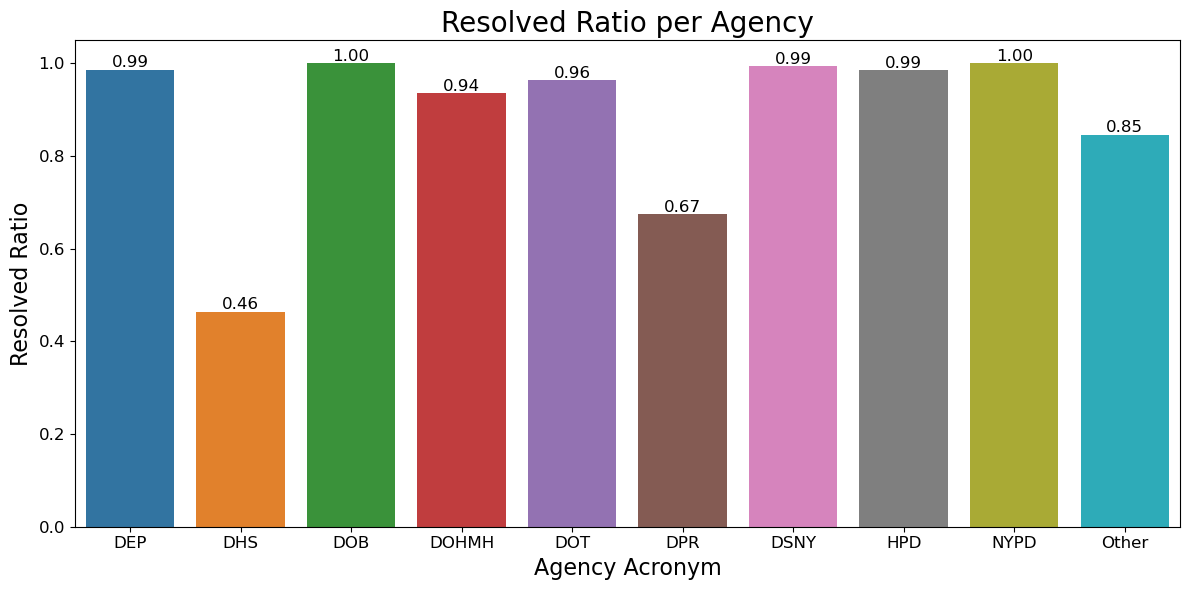

Figure saved as ../visualizations/resolved_ratio_by_agency.png with 300 DPI.


In [14]:
# Calculate resolved ratio per agency
resolved_ratio = df.groupby('agency_acronym')['resolved'].mean().reset_index()

# Plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(data = resolved_ratio, x = 'agency_acronym', y = 'resolved', ax = ax,
            hue = 'agency_acronym', palette = 'tab10')

# Add annotations
add_bar_labels(ax)

# Format plot
format_axis(ax, 'Resolved Ratio per Agency', 'Agency Acronym', 'Resolved Ratio')
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/resolved_ratio_by_agency.png')

### Temporal Patterns

The next step is to see if there are any temporal patterns to the complaints. The raw number of complaints is highest in the afternoon (12:00pm to 5:59pm) and lowest during the night (12:00am to 5:59 am), which is to be expected as there is more activity during the middle of the day compared to the night. The number of complaints during daytime hours are all close.

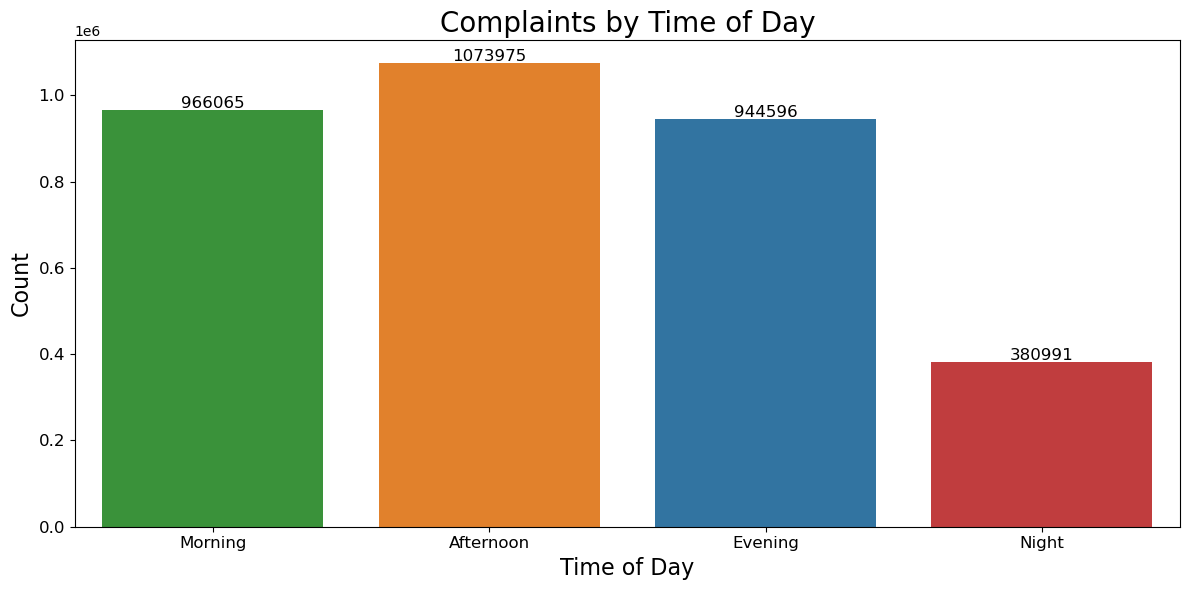

Figure saved as ../visualizations/complaints_by_time_of_day.png with 300 DPI.


In [15]:
# Define time of day order
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']

# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'time_of_day', hue = 'time_of_day', order = time_order, palette = 'tab10', ax = ax)

# Format and annotate
format_axis(ax, 'Complaints by Time of Day', 'Time of Day', 'Count')
add_bar_labels(ax, fmt = "{:.0f}")
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/complaints_by_time_of_day.png')

As expected, most of the agencies operate during the daylight hours, with only the NYPD having any significant presence during the nighttime hours.

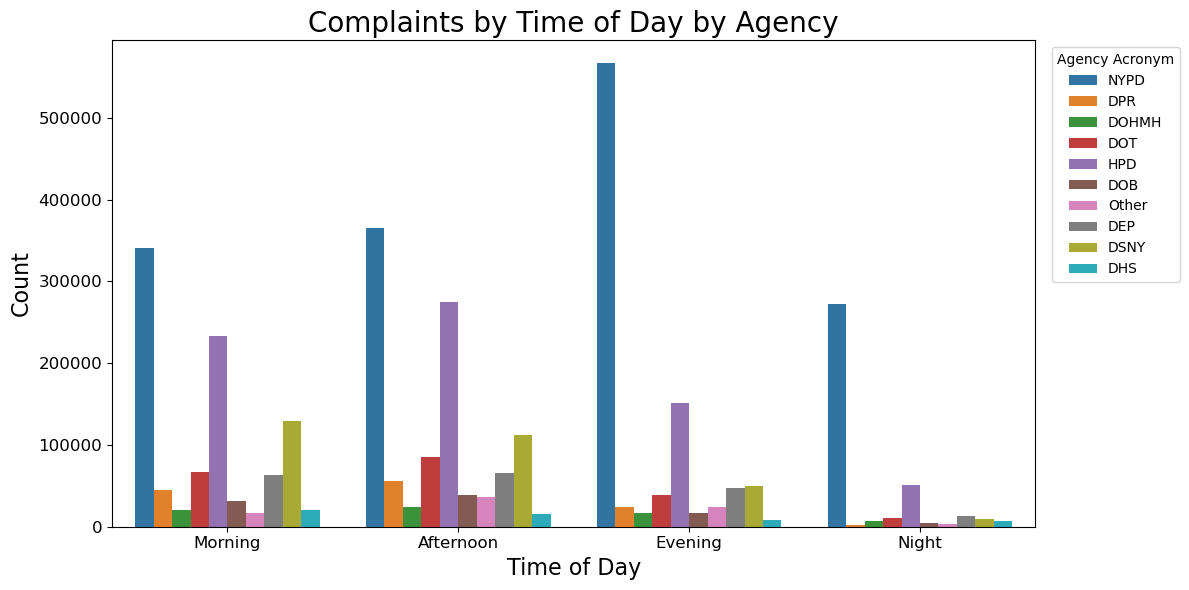

Figure saved as ../visualizations/complaints_by_time_of_day_by_agency.png with 300 DPI.


In [16]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'time_of_day', hue = 'agency_acronym', order = time_order, ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Complaints by Time of Day by Agency', 'Time of Day', 'Count')

# Move legend to the right
plt.legend(title = 'Agency Acronym', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust x-ticks and layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/complaints_by_time_of_day_by_agency.png')

Checking the number of complaints across the course of the week shows an interesting trend. Complaints are more likely to occur earlier in the week, trending downwards until the weekend. This seems to indicate that people are less likely to call 311 later on in the week, instead deferring any non-urgent complaints until the start of the work-week.

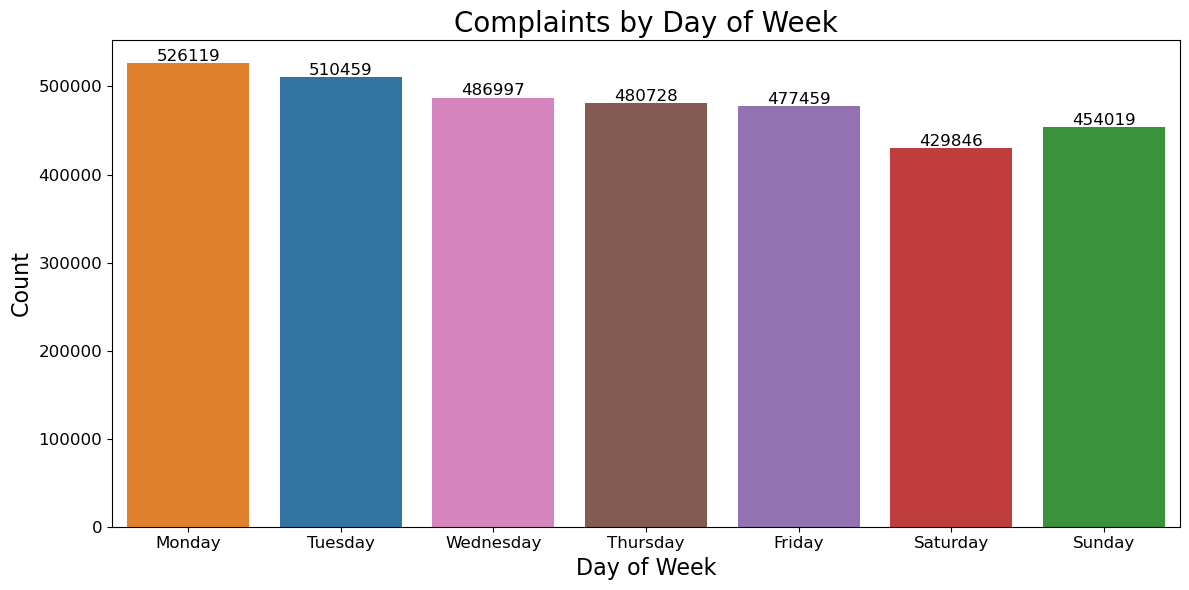

Figure saved as ../visualizations/complaints_by_day_of_week.png with 300 DPI.


In [17]:
# Ensure correct day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'day_of_week', hue = 'day_of_week', order = day_order, palette = 'tab10', ax = ax)

# Add annotations
add_bar_labels(ax, fmt = "{:.0f}")

# Format plot
format_axis(ax, 'Complaints by Day of Week', 'Day of Week', 'Count')
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/complaints_by_day_of_week.png')

Viewing the complaints by day of week broken down by agency reveals that the NYPD is the main agency handling complaints over the weekend. This makes sense, as most of the other agencies operate under normal business hours.

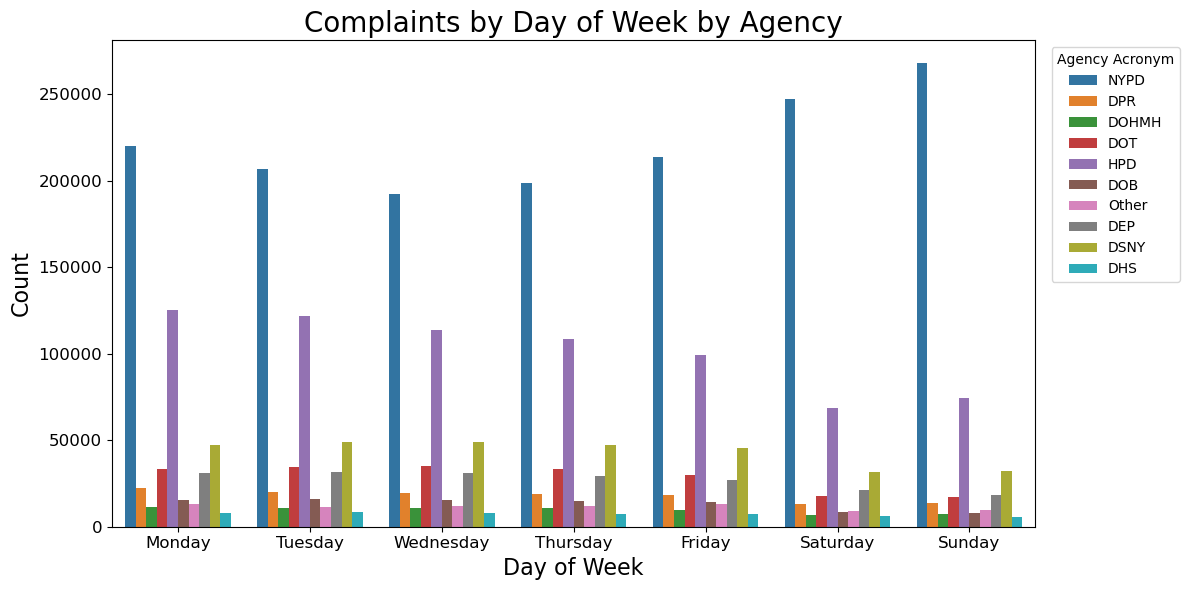

Figure saved as ../visualizations/complaints_by_day_of_week_by_agency.png with 300 DPI.


In [18]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'day_of_week', hue = 'agency_acronym', order = day_order, ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Complaints by Day of Week by Agency', 'Day of Week', 'Count')

# Move legend to the right
plt.legend(title = 'Agency Acronym', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust x-ticks and layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/complaints_by_day_of_week_by_agency.png')

The majority of complaints over the weekend are noise complaints, which makes sense as these are the days of the week when events such as parties, etc. are held and most people are at home. Noise complaints are handled almost exclusively by the NYPD, which explains why the NYPD is the most prevalent agency answering 311 calls over the weekend.

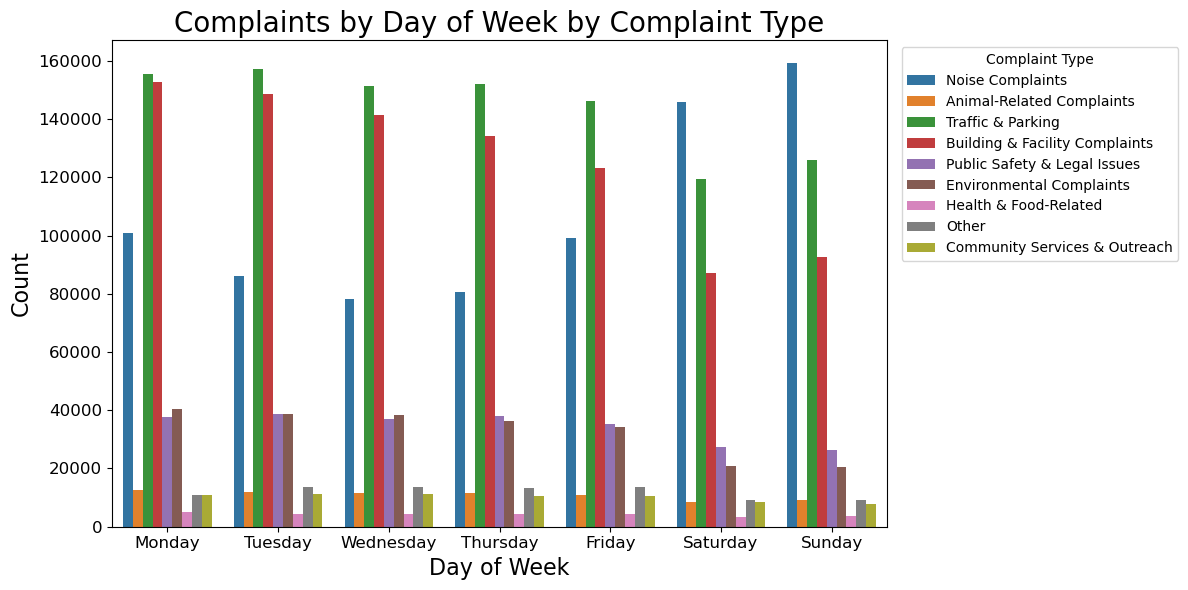

Figure saved as ../visualizations/complaints_by_day_of_week_by_complaint_type.png with 300 DPI.


In [19]:
# Ensure correct day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'day_of_week', hue = 'complaint_type',
              order = day_order, palette = 'tab10', ax = ax)

# Format plot
format_axis(ax, 'Complaints by Day of Week by Complaint Type', 'Day of Week', 'Count')

# Move legend to the right
plt.legend(title = 'Complaint Type', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust layout
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/complaints_by_day_of_week_by_complaint_type.png')

Viewing the number of complaints by month shows that there appear to be generally more complaints during the summer and fall months, with comparatively few in spring. February is an outlier, as expected since it is shorter, but otherwise, the level of complaints stays roughly the same throughout the year.

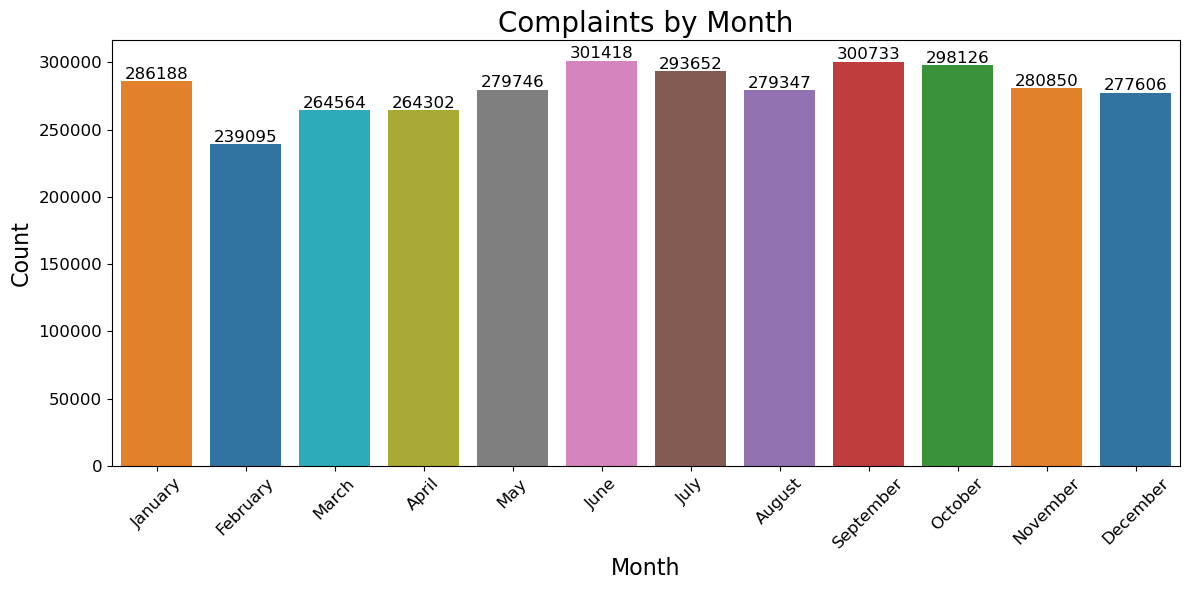

Figure saved as ../visualizations/complaints_by_month.png with 300 DPI.


In [20]:
# Month names order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'month', order = month_order, ax = ax, hue = 'month', palette = 'tab10')
format_axis(ax, 'Complaints by Month', 'Month', 'Count')
add_bar_labels(ax, fmt = '{:.0f}')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/complaints_by_month.png')

Looking at the distribution of complaints by month, it becomes clear that there are many more housing complaints handled by the HPD during the winter months (January and December) and more sanitation or enivornmental complaints handled by the DSNY (Department of Sanitation) and the DEP (Department of Environmental Protection) during the summer. Complaints handled by the NYPD seem to also increase during the Summer and Fall months.

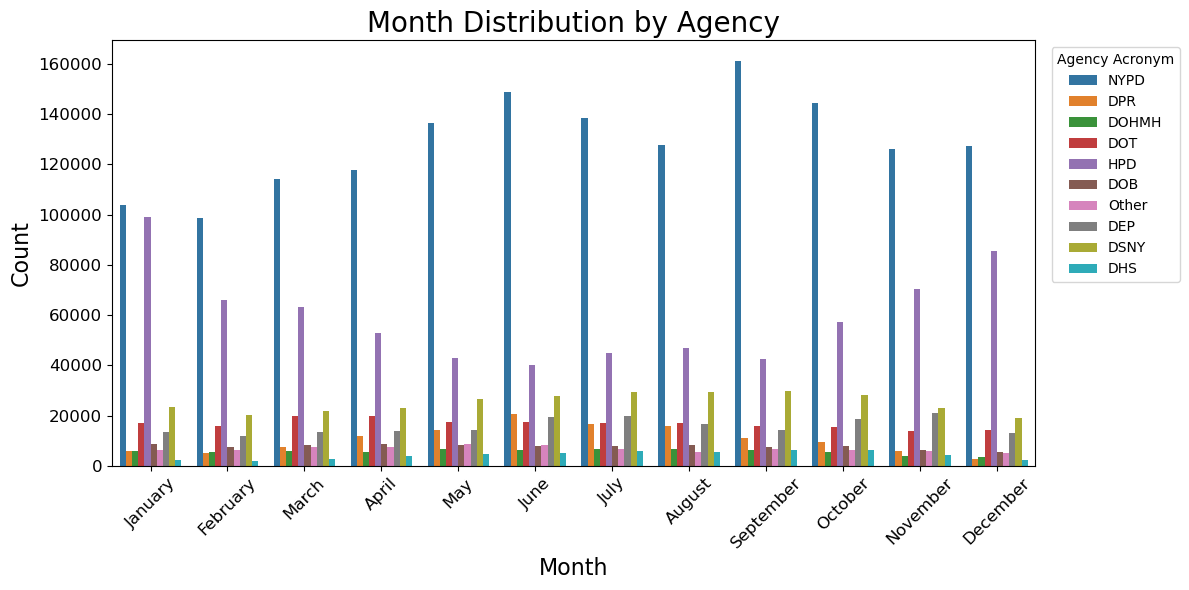

Figure saved as ../visualizations/complaints_by_month_by_agency.png with 300 DPI.


In [21]:
# Create the plot
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(data = df, x = 'month', hue = 'agency_acronym', order = month_order, ax = ax, palette = 'tab10')

# Format plot
format_axis(ax, 'Month Distribution by Agency', 'Month', 'Count')

# Move legend to the right
plt.legend(title = 'Agency Acronym', bbox_to_anchor = (1.01, 1), loc = 'upper left')

# Adjust x-ticks and layout
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/complaints_by_month_by_agency.png')

### Correlation and Feature Analysis

Most of the relevant features for modeling in the data are categorical. As such, correlation heatmaps are not useful, so we perform a pair-wise Chi-squared test for independence on each categorical feature to see if the features are independent. High Chi-square values / low p-values indicate that the variables are not independent and have a relationship between them.

In [22]:
# Select only categorical columns
categorical_cols = ['complaint_type', 'location_type', 'borough', 'incident_zip',
                    'time_of_day', 'day_of_week', 'month', 'agency_acronym', ]

# Store results
chi2_results = []

# Loop over all combinations of categorical columns
for col1, col2 in combinations(categorical_cols, 2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    
    if contingency_table.size > 1:  # skip if degenerate
        chi2, p, dof, expected = chi2_contingency(contingency_table, correction = False)
        chi2_results.append({
            'Feature 1': col1,
            'Feature 2': col2,
            'Chi2': chi2,
            'p-value': p,
            'Degrees of Freedom': dof
        })

# Convert results to a DataFrame and sort by p-value
chi2_df = pd.DataFrame(chi2_results).sort_values(by = 'p-value')

# Display results
print(chi2_df)

         Feature 1       Feature 2          Chi2  p-value  Degrees of Freedom
0   complaint_type   location_type  2.674492e+06      0.0                  40
25     day_of_week           month  5.744017e+04      0.0                  66
24     time_of_day  agency_acronym  3.150450e+05      0.0                  27
23     time_of_day           month  8.753370e+03      0.0                  33
22     time_of_day     day_of_week  6.238176e+04      0.0                  18
21    incident_zip  agency_acronym  1.541348e+06      0.0                2187
20    incident_zip           month  1.067706e+05      0.0                2673
19    incident_zip     day_of_week  3.086645e+04      0.0                1458
18    incident_zip     time_of_day  6.608032e+04      0.0                 729
17         borough  agency_acronym  3.254560e+05      0.0                  36
16         borough           month  1.406910e+04      0.0                  44
15         borough     day_of_week  3.202264e+03      0.0       

All of the chi-squared p-values are below 0.05, indicating significant relations between variables. However, by looking at the normalized chi-squared value (chi-squared / degrees of freedom), it becomes clear that the most relevant values to the target variable agency_acronym are complaint type, location type, time of day, and borough. Location type and complaint type do appear to be highly related as well.

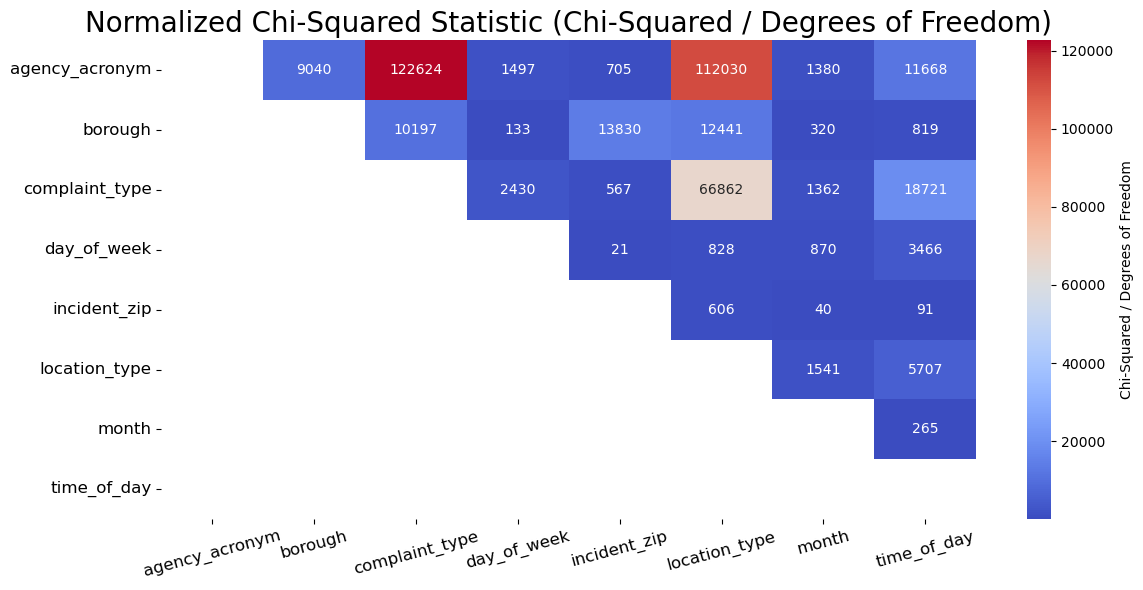

Figure saved as ../visualizations/chi_squared_correlations.png with 300 DPI.


In [23]:
# Create a matrix for normalized Chi-squared (Chi-squared / degrees of freedom)
chi2_df['Chi2_norm'] = chi2_df['Chi2'] / chi2_df['Degrees of Freedom']

features = sorted(set(chi2_df['Feature 1']).union(chi2_df['Feature 2']))
norm_matrix = pd.DataFrame(np.nan, index=features, columns=features)

# Fill matrix with normalized Chi-squared statistic
for _, row in chi2_df.iterrows():
    f1, f2, chi2_norm = row['Feature 1'], row['Feature 2'], row['Chi2_norm']
    norm_matrix.loc[f1, f2] = chi2_norm
    norm_matrix.loc[f2, f1] = chi2_norm

# Create the mask for the lower triangle
mask = np.tril(np.ones_like(norm_matrix, dtype = bool))

# Plot heatmap
fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(norm_matrix, annot = True, fmt = ".0f", cmap = "coolwarm",
            mask = mask, cbar_kws = {'label': 'Chi-Squared / Degrees of Freedom'})
format_axis(ax, 'Normalized Chi-Squared Statistic (Chi-Squared / Degrees of Freedom)', '', '')
plt.xticks(rotation = 15)
plt.tight_layout()
plt.show()

# Save plot
save_figure_to_png(fig, filename = '../visualizations/chi_squared_correlations.png')

### Spatial Analysis (GeoPandas map using Folium)

Some testing with GeoPandas to see how the complaints are distributed graphically on a map. Not much to be gained from this visual other than to be able to explore how the complaints appear spatially in a visual sense.

In [24]:
# Regenerate the geometry column for spatial plotting (this takes a long time to run)
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis = 1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry = 'geometry', crs = 'EPSG:4326')

In [25]:
# Note: This may take a long time to run!
# Create a folium map centered around the average location of all boroughs
center_lat, center_lon = df['geometry'].apply(lambda x: x.y if isinstance(x, Point) else None).mean(), \
                        df['geometry'].apply(lambda x: x.x if isinstance(x, Point) else None).mean()

m = folium.Map(location = [center_lat, center_lon], zoom_start = 11, tiles = 'cartodbpositron')

# Create a MarkerCluster to group markers
marker_cluster = MarkerCluster().add_to(m)

# Group by borough and sample 0.1% of the data for each borough
sampled_df = df.groupby('borough').apply(
    lambda x: x.sample(frac = 0.001)
).reset_index(drop = True)

# Generate a color palette for each borough
boroughs = sampled_df['borough'].unique()
color_palette = sns.color_palette("tab10", n_colors = len(boroughs))
borough_color_map = {borough: color_palette[i] for i, borough in enumerate(boroughs)}

# Add CircleMarkers for each sampled point, color-coded by borough
for _, row in sampled_df.iterrows():
    color = borough_color_map[row['borough']]
    
    folium.CircleMarker(
        location = [row['latitude'], row['longitude']],
        radius = 4,
        color = f'rgba({int(color[0] * 255)}, {int(color[1] * 255)}, {int(color[2] * 255)}, 1)', # RGB color
        fill = True,
        fill_opacity = 0.4,
        popup = f"Complaint ID: {row.name}<br>Borough: {row['borough']}",
    ).add_to(marker_cluster)

# Display the map
m

/tmp/ipykernel_75230/234327185.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('borough').apply(


### Remove Extra Columns in Preparation for Modeling

In [26]:
# Inspect columns to see which need to be removed
df.columns

Index(['agency_name', 'complaint_type', 'location_type', 'incident_zip',
       'borough', 'latitude', 'longitude', 'time_of_day', 'day_of_week',
       'month', 'resolution_time_hours', 'resolved', 'agency_acronym',
       'geometry'],
      dtype='object')

We don't need agency name anymore, as it is equivalent to agency acronym but longer. We don't need the Latitude and Longitude spatial data for modeling, nor do we need the time to resolution or resolution status to predict which agency the 311 call should be directed towards, as these features are calculated after the fact. Day of Week and Month show some interesting patterns, but the most useful categorical features appear to be Borough, Complaint Type, Location Type, and Time of Day. We will also keep the Incident Zip for modeling to preserve some amount of location data that is more granular than Borough, even though the Incident Zip does not have as strong of a relation from the Chi-Squared tests.

In [27]:
# Subset on columns for modeling
df = df[['agency_acronym', 'borough', 'complaint_type', 'location_type', 'time_of_day', 'incident_zip']]

In [28]:
# Write to csv for modeling - still needs one-hot-encoding and train-test split
df.to_csv('../data/cleaned/311_Data_Cleaned_Modeling.csv.bz2',
          compression = {'method': 'bz2', 'compresslevel': 9}, index = False)